In [1]:
import decode_eeg
import numpy as np
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)

# Color to Orientation

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [4]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle, isub)

# Set up interp object and save results.
interp_color = decode_eeg.Interpreter(clfr,subtitle=f'color_to_ori_trialbin{trial_average}_')
interp_color.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [4]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp_color = decode_eeg.Interpreter()
interp_color.load_results(filename = 'color_to_ori_trialbin20.pickle')

# Orientation to Color

In [5]:
# Classification parameters and setup

time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=4)

In [12]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub,sub in enumerate(sync.matched_ids):
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# setup interp object and save results
interp = decode_eeg.Interpreter(clfr,subtitle=f'ori_to_color_{trial_average}_')
interp.save_results()

In [6]:
# Set up interp object and load pre-existing results.
interp = decode_eeg.Interpreter()
interp.load_results('ori_to_color_trialbin20.pickle')

# Plot both directions of classification generalization

In [7]:
# Combine acc matrices for plotting
interp.acc = np.concatenate([interp.acc[:,np.newaxis],interp_color.acc[:,np.newaxis]],1)
interp.acc_shuff = np.concatenate([interp.acc_shuff[:,np.newaxis],interp_color.acc_shuff[:,np.newaxis]],1)

Color to orientation significant timepoints: [ 160  184  208  232  256  280  304  328  352  376  400  424  448  472
  496  520  544  568  592  616  640  664  688  712  736  760  784  808
  832  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144
 1168 1192]
Color to orientation mean delay accuracy: 0.332328125
Color to orientation mean delay S.D.: 0.027419225772856208
Orientation to color significant timepoints: [  64  208  232  256  280  304  328  352  376  400  424  448  472  496
  520  544  568  592  616  640  664  688  712  736  760  784  808  832
  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144 1168
 1192]
Orientation to color mean delay accuracy: 0.3340698115079365
Orientation to color mean delay S.D.: 0.027257937437230564
Saving output\figures\acc_single_feature.pdf
Saving output\figures\acc_single_feature.png


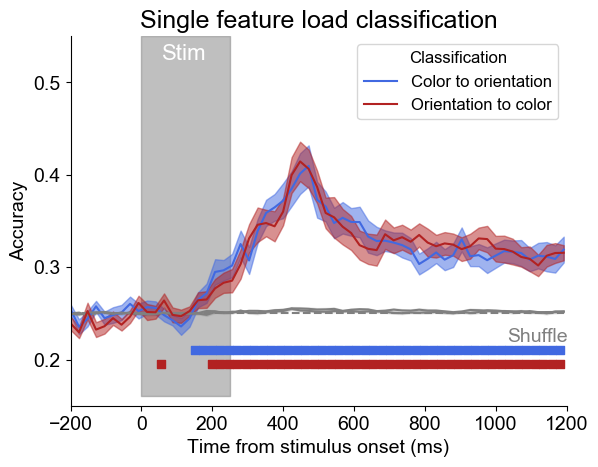

In [9]:
interp.plot_acc_subset(
    subset_list=['Color to orientation','Orientation to color'],
    ylim=[.15,.55], 
    chance=.25, 
    sig_ys=[.21,.195], 
    chance_text_y=.211,
    significance_testing=True,
    title='Single feature load classification',
    subtitle='_single_feature',
    savefig=True)

# Compare within to across

In [49]:
interp_color_to_ori = decode_eeg.Interpreter()
interp_color_to_ori.load_results(filename = 'color_to_ori_trialbin20.pickle')
interp_ori_to_color = decode_eeg.Interpreter()
interp_ori_to_color.load_results('ori_to_color_trialbin20.pickle')

interp_color = decode_eeg.Interpreter()
interp_color.load_results('1801_trialbin20.pickle')
interp_ori = decode_eeg.Interpreter()
interp_ori.load_results('1901_trialbin20.pickle')

### Color

In [50]:
# loading sync to get ids used in single feature cross-training
wrangl = decode_eeg.Wrangler(exp1.info['times'],1,5,1,1,{})
sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1])
matched_ids = np.array(sync.matched_ids)                                    

In [37]:
unique_ids = []
for isub in range(exp1.nsub):
    info = exp1.load_info(isub)
    unique_ids.append(int(info['unique_id']))
unique_ids = np.array(unique_ids)

matched_idx = np.in1d(unique_ids,matched_ids)
interp_color.acc = interp_color.acc[matched_idx]
interp_color.acc_shuff = interp_color.acc_shuff[matched_idx]

In [40]:
# Combine acc matrices for plotting
interp_color.acc = np.concatenate([interp_color.acc[:,np.newaxis],interp_ori_to_color.acc[:,np.newaxis]],1)
interp_color.acc_shuff = np.concatenate([interp_color.acc_shuff[:,np.newaxis],interp_ori_to_color.acc_shuff[:,np.newaxis]],1)

Within session color significant timepoints: [  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
  760  784  808  832  856  880  904  928  952  976 1000 1024 1048 1072
 1096 1120 1144 1168 1192]
Within session color mean delay accuracy: 0.4160641431051587
Within session color mean delay S.D.: 0.04164505977704251
Orientation to color significant timepoints: [ 160  184  208  232  256  280  304  328  352  376  400  424  448  472
  496  520  544  568  592  616  640  664  688  712  736  760  784  808
  832  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144
 1168 1192]
Orientation to color mean delay accuracy: 0.332328125
Orientation to color mean delay S.D.: 0.027419225772856208


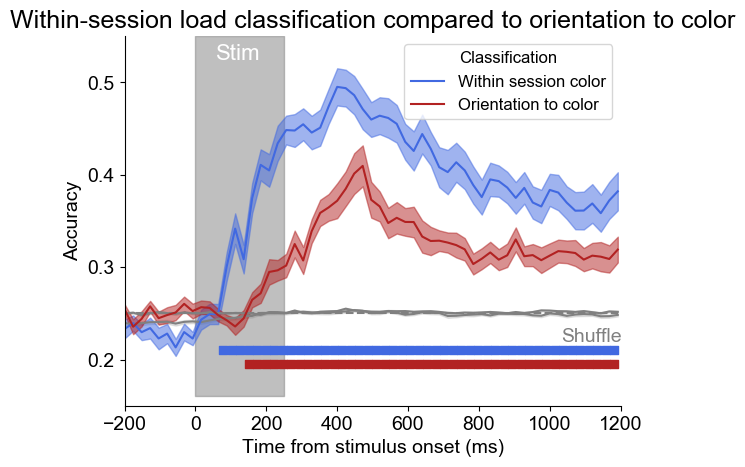

In [44]:
interp_color.plot_acc_subset(
    subset_list=['Within session color','Orientation to color'],
    ylim=[.15,.55], 
    chance=.25, 
    sig_ys=[.21,.195], 
    chance_text_y=.211,
    significance_testing=True,
    title='Within-session load classification compared to orientation to color',
    subtitle='within_to_ori_color',
    savefig=False)

### Ori

In [51]:
unique_ids = []
for isub in range(exp2.nsub):
    info = exp2.load_info(isub)
    unique_ids.append(int(info['unique_id']))
unique_ids = np.array(unique_ids)

matched_idx = np.in1d(unique_ids,matched_ids)
interp_ori.acc = interp_ori.acc[matched_idx]
interp_ori.acc_shuff = interp_ori.acc_shuff[matched_idx]

In [52]:
# Combine acc matrices for plotting
interp_ori.acc = np.concatenate([interp_ori.acc[:,np.newaxis],interp_color_to_ori.acc[:,np.newaxis]],1)
interp_ori.acc_shuff = np.concatenate([interp_ori.acc_shuff[:,np.newaxis],interp_color_to_ori.acc_shuff[:,np.newaxis]],1)

d:\archery\decode_eeg.py:758: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


Within session orientation significant timepoints: [ 160  184  208  232  256  280  304  328  352  376  400  424  448  472
  496  520  544  568  592  616  640  664  688  712  736  760  784  808
  832  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144
 1168 1192]
Within session orientation mean delay accuracy: 0.42939776165674604
Within session orientation mean delay S.D.: 0.03712902214212897
Color to orientation significant timepoints: [  64  208  232  256  280  304  328  352  376  400  424  448  472  496
  520  544  568  592  616  640  664  688  712  736  760  784  808  832
  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144 1168
 1192]
Color to orientation mean delay accuracy: 0.3340698115079365
Color to orientation mean delay S.D.: 0.027257937437230564


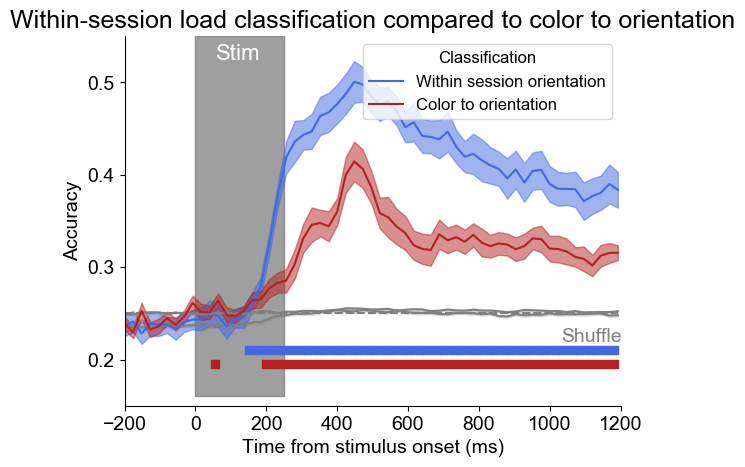

In [54]:
interp_ori.plot_acc_subset(
    subset_list=['Within session orientation','Color to orientation'],
    ylim=[.15,.55], 
    chance=.25, 
    sig_ys=[.21,.195], 
    chance_text_y=.211,
    significance_testing=True,
    title='Within-session load classification compared to color to orientation',
    subtitle='within_to_ori_color',
    savefig=False)